In [1]:
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Some Sample Functions for testing the interpolation in 1 and 2D
###################################################################
def gaussian( x_val ):
    output =  1/np.sqrt(2*np.pi)*np.exp(-(x_val-0.5)**2/2)
    return output

def quad( x_val ):
    output = -1*(x_val-0.5)**2+0.5**2
    return output

def quad_2D(x_val, y_val):
    #output = -1*((x_val-0.5)**2+(y_val-0.5)**2)+2*0.5**2 #no good
    #output = -1*((x_val + y_val-0.5)**2)+0.5**2 #no good
    output = x_val*(x_val-1)*y_val*(y_val-1)
    return output
###################################################################

# Some underlying functions needed for the interpolation
###################################################################
def build_hat(level, node, domain):
    mesh_size = 1/(2**(level))
    hat_function = np.zeros(len(domain))
    hat_function = 1 - np.abs(domain/mesh_size - node)
    for i in range(len(hat_function)):
        if hat_function[i]<0:
            hat_function[i] = 0        
    return hat_function

def find_coe_1D(level, node, func):
    mesh_size = 1/(2**(level))
    point1 = func(node*mesh_size)
    point2 = func((node-1)*mesh_size)
    point3 = func((node+1)*mesh_size)
    
    coe = point1 - (point2+point3)/2
    return coe

def find_coe_2D(level1, level2, node1, node2, func):
    mesh_size1 = 1/(2**(level1))
    mesh_size2 = 1/(2**(level2))
    
    point = np.zeros(9)
    point[0] = func((node1)*mesh_size1,(node2)*mesh_size2)
    point[1] = func((node1-1)*mesh_size1,(node2)*mesh_size2) 
    point[2] = func((node1+1)*mesh_size1,(node2)*mesh_size2) 
    point[3] = func((node1)*mesh_size1,(node2-1)*mesh_size2) 
    point[4] = func((node1-1)*mesh_size1,(node2-1)*mesh_size2) 
    point[5] = func((node1+1)*mesh_size1,(node2-1)*mesh_size2) 
    point[6] = func((node1)*mesh_size1,(node2+1)*mesh_size2) 
    point[7] = func((node1-1)*mesh_size1,(node2+1)*mesh_size2) 
    point[8] = func((node1+1)*mesh_size1,(node2+1)*mesh_size2)
    
    coe = point[0]  
    coe = coe - (point[1]+point[2]+point[3]+point[6])/2
    coe = coe + (point[5]+point[4]+point[7]+point[8])/4
    
    return coe
###################################################################

# Functions to create the dense grid interpolation via the hierarchical basis.
###################################################################

# Creates the 1D interpolation given a max_level of resolution, a domain, and a function,
def dense_interpolation_1D(max_level, domain, func):  
    level = np.arange(1,max_level+1,1)
    func_approx = np.zeros(len(domain))
    
    for l in level:
        start_node = 1
        nodes = np.arange(start_node, 2**(l),2)
        for node in nodes:
            hat_hold = build_hat(l,node, domain)
            coe_hold = find_coe_1D(l,node,func)
            plt.plot(domain, coe_hold*hat_hold) #To visualize hat functions.
            func_approx = func_approx + coe_hold*hat_hold  
    plt.show()                                  #To visualize hat functions.
    return func_approx

# Creates the 2D interpolation given a max_level of resolution, a 1D domain, and a function
# Returns the approximation and it's level of resolution.
def dense_interpolation_2D(max_level, domain, func):
    
    #X,Y = np.meshgrid(domain,domain)
    #fig = plt.figure(figsize=plt.figaspect(2.));
    #ax = fig.add_subplot(1,1,1, projection='3d');
    
    
    level_single = np.arange(1,max_level+1,1)
    func_approx = np.zeros((len(domain),len(domain)))
    levels = list(product(level_single,level_single))
    #print(levels)
    for level in levels:                  
            start_node = 1
            nodes1 = np.arange(start_node,2**(level[0]),2)
            nodes2 = np.arange(start_node,2**(level[1]),2)
            nodes = list(product(nodes1,nodes2))
            #print(nodes)
            for node in nodes:           
                    hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
                    coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
                    #ax.plot_surface(X,Y,coe_hold*hat_hold, rstride=1, cstride=1) #To visualize hat functions. Not useful
                    func_approx = func_approx + coe_hold*hat_hold
    #plt.show()                                                         #To visualize hat functions. Not useful
    return func_approx, max_level

# Increases the level of resolution of an interpolation given the new level, domain, function, and current approximation.
# Returns the new approxmation and the new level of resolution.
# Note: can only increase level by 1.
def add_level_2D(new_level, domain, func, func_approx):
    old_level_single = np.arange(1,new_level,1)
    new_levels_y = list(product(old_level_single,np.array([new_level])))
    new_levels_x = list(product(np.array([new_level]),old_level_single))
    
    for level in new_levels_x:
        start_node = 1
        nodes1 = np.arange(start_node,2**(level[0]),2)
        nodes2 = np.arange(start_node,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:           
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            func_approx = func_approx + coe_hold*hat_hold
    
    for level in new_levels_y:
        start_node = 1
        nodes1 = np.arange(start_node,2**(level[0]),2)
        nodes2 = np.arange(start_node,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:           
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            func_approx = func_approx + coe_hold*hat_hold
            
    level = np.array([new_level,new_level])
    start_node = 1
    nodes1 = np.arange(start_node,2**(level[0]),2)
    nodes2 = np.arange(start_node,2**(level[1]),2)
    nodes = list(product(nodes1,nodes2))
    for node in nodes:           
        hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
        coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
        func_approx = func_approx + coe_hold*hat_hold
    
    return func_approx, new_level
###################################################################    
    
    

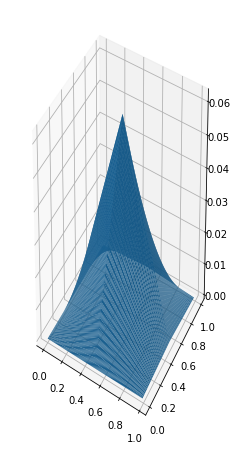

In [2]:
# Example of 2D dense interpolation.

domain_start = 0
domain_end = 1
domain = np.arange(domain_start, domain_end, 0.01)
X,Y = np.meshgrid(domain,domain)
initial_level = 1 #Set level here.

fig = plt.figure(figsize=plt.figaspect(2.)); # 3D ploting 
ax = fig.add_subplot(1,1,1, projection='3d');# 3D ploting

Z1, current_level = dense_interpolation_2D(initial_level,domain,quad_2D);
ax.plot_surface(X,Y,Z1, rstride=1, cstride=1)# 3D ploting
plt.show()

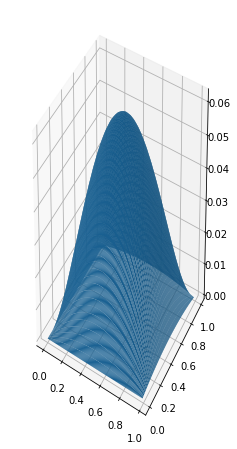

In [6]:
# Example using the add level function for the previous example.

X,Y = np.meshgrid(domain,domain)
fig = plt.figure(figsize=plt.figaspect(2.));# 3D ploting 
ax = fig.add_subplot(1,1,1, projection='3d');# 3D ploting 

Z1 , current_level= add_level_2D(current_level+1, domain, quad_2D, Z1)
ax.plot_surface(X,Y,Z1, rstride=1, cstride=1)# 3D ploting 
plt.show()

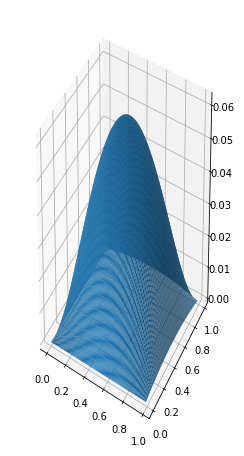

In [3]:
# Actual function being approximate in previous example.
X,Y = np.meshgrid(domain,domain)
fig = plt.figure(figsize=plt.figaspect(2.));# 3D ploting 
ax = fig.add_subplot(1,1,1, projection='3d');# 3D ploting 

Z2 = quad_2D(X,Y)

ax.plot_surface(X,Y,Z2, rstride=1, cstride=1)# 3D ploting 
plt.show()

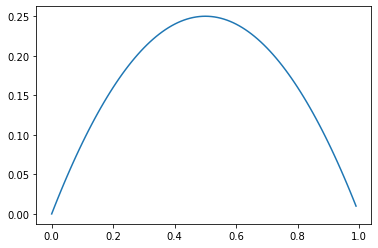

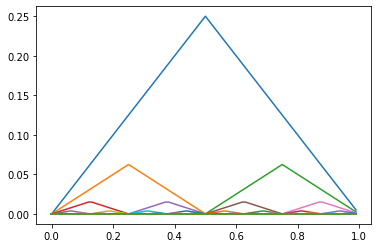

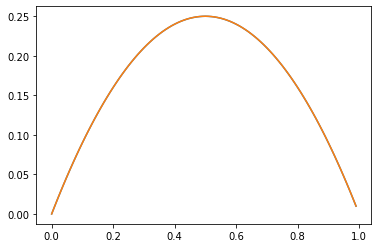

In [10]:
# Sample of 1D dense interpolation.
plt.plot(domain, quad(domain))
plt.show()

y = dense_interpolation_1D(6,domain,quad)

plt.plot(domain,y)
plt.plot(domain, quad(domain))
plt.show()